Using device: cuda
--- Character Data Ready. Vocab: 80 ---

>>> Training: Config 1 (H=128, L=1, D=0.0)
    Params: H=128 | L=1 | Drop=0.0 | Ep=20
    Epoch 1: Time 1.2s | Train Loss 2.7098 | Val Loss 2.2794 | PPL 9.7709
    Epoch 2: Time 0.3s | Train Loss 2.0912 | Val Loss 1.9677 | PPL 7.1540
    Epoch 3: Time 0.3s | Train Loss 1.8674 | Val Loss 1.8067 | PPL 6.0901
    Epoch 4: Time 0.3s | Train Loss 1.7370 | Val Loss 1.7093 | PPL 5.5251
    Epoch 5: Time 0.3s | Train Loss 1.6506 | Val Loss 1.6408 | PPL 5.1594
    Epoch 6: Time 0.4s | Train Loss 1.5856 | Val Loss 1.5891 | PPL 4.8996
    Epoch 7: Time 0.4s | Train Loss 1.5352 | Val Loss 1.5490 | PPL 4.7068
    Epoch 8: Time 0.3s | Train Loss 1.4954 | Val Loss 1.5157 | PPL 4.5527
    Epoch 9: Time 0.3s | Train Loss 1.4630 | Val Loss 1.4886 | PPL 4.4310
    Epoch 10: Time 0.3s | Train Loss 1.4359 | Val Loss 1.4673 | PPL 4.3377
    Epoch 11: Time 0.3s | Train Loss 1.4127 | Val Loss 1.4495 | PPL 4.2610
    Epoch 12: Time 0.3s | Train Loss 1

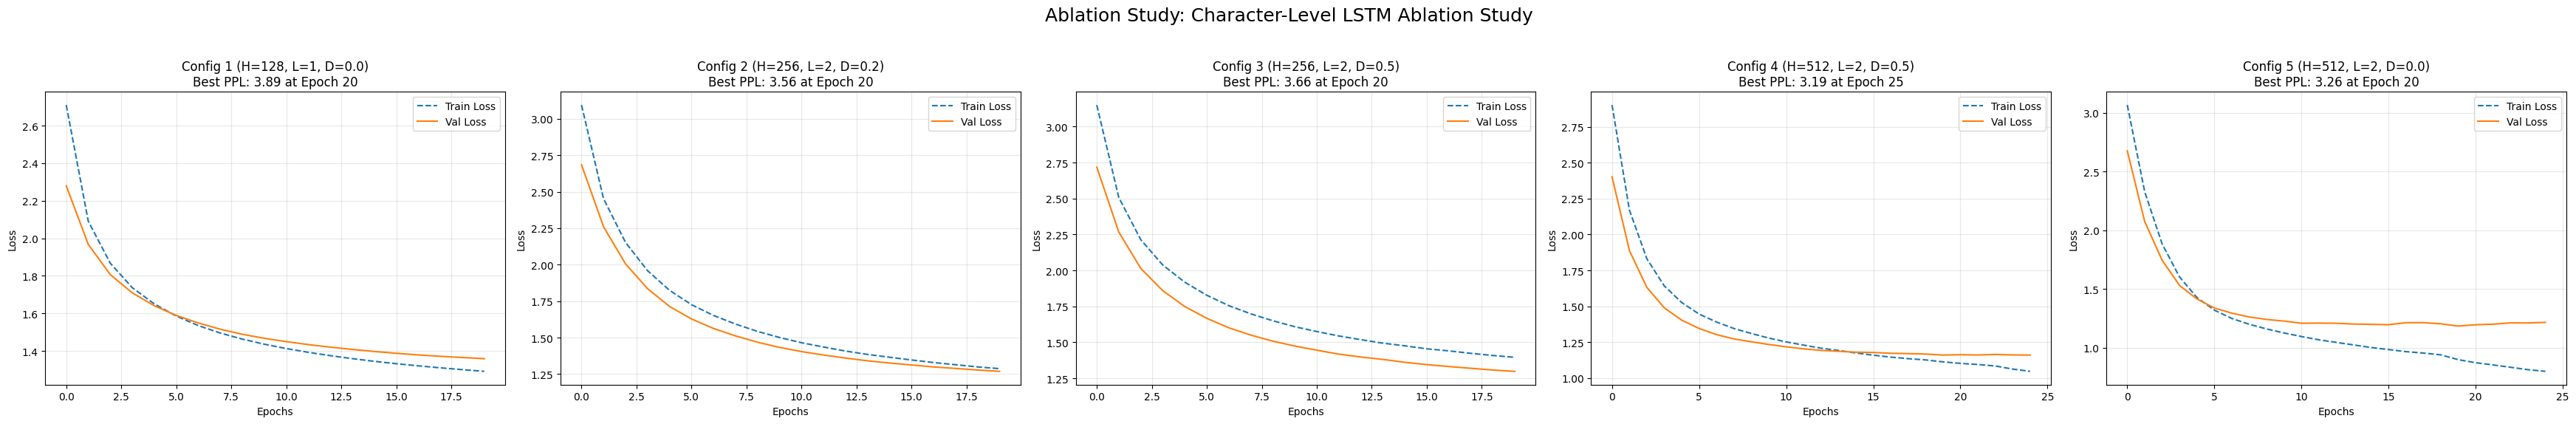

In [2]:
# --- 1. Imports and Setup ---
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import re

# --- 2. Configuration ---
FILE_PATH = '/content/Pride_and_Prejudice-Jane_Austen.txt'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 3. The LSTM Model ---
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, n_layers, dropout=0.5):
        super(LSTMModel, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # PyTorch warning: dropout > 0 on a 1-layer LSTM is not applied.
        # We'll set it to 0 if n_layers is 1.
        lstm_dropout = dropout if n_layers > 1 else 0

        self.lstm = nn.LSTM(embed_dim, hidden_dim, n_layers,
                            dropout=lstm_dropout,
                            batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden):
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = self.dropout(lstm_out)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(lstm_out)
        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        # Initialize both hidden state and cell state
        return (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))

# --- 4. Batch Generator ---
def get_batches(arr, batch_size, seq_length):
    batch_size_total = batch_size * seq_length
    n_batches = len(arr) // batch_size_total
    arr = arr[:n_batches * batch_size_total]
    arr = arr.reshape((batch_size, -1))
    for n in range(0, arr.shape[1], seq_length):
        x = arr[:, n:n+seq_length]
        y = np.zeros_like(x)
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n+seq_length]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
        yield torch.from_numpy(x), torch.from_numpy(y)

# --- 5. The Experiment Runner (with LR Scheduler) ---
def run_experiment(train_data, val_data, vocab_size, configs, seq_len):
    results = {}

    for name, conf in configs.items():
        print(f"\n>>> Training: {name}")
        print(f"    Params: H={conf['hidden_dim']} | L={conf['n_layers']} | Drop={conf['dropout']} | Ep={conf['epochs']}")

        model = LSTMModel(vocab_size, conf['embed_dim'], conf['hidden_dim'], conf['n_layers'], conf['dropout']).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=conf['lr'])
        criterion = nn.CrossEntropyLoss()

        # *** NEW: Add Learning Rate Scheduler ***
        # This will reduce the LR by half (factor=0.5) if val_loss doesn't improve for 2 epochs (patience=2)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2)

        history = {'train_loss': [], 'val_loss': [], 'val_ppl': [], 'train_time': 0.0}
        start_time = time.time()

        for epoch in range(1, conf['epochs'] + 1):
            epoch_start = time.time()
            model.train()
            h = model.init_hidden(conf['batch_size'])
            train_losses = []

            for x, y in get_batches(train_data, conf['batch_size'], seq_len):
                x, y = x.long().to(device), y.long().to(device)
                h = tuple([each.data for each in h]) # Detach LSTM hidden state tuple
                model.zero_grad()
                output, h = model(x, h)
                loss = criterion(output, y.view(-1))
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), 5) # Gradient Clipping
                optimizer.step()
                train_losses.append(loss.item())

            # Validation
            model.eval()
            val_h = model.init_hidden(conf['batch_size'])
            val_losses = []
            with torch.no_grad():
                for x, y in get_batches(val_data, conf['batch_size'], seq_len):
                    x, y = x.long().to(device), y.long().to(device)
                    val_h = tuple([each.data for each in val_h])
                    output, val_h = model(x, val_h)
                    val_loss = criterion(output, y.view(-1))
                    val_losses.append(val_loss.item())

            # Stats
            avg_train = np.mean(train_losses)
            avg_val = np.mean(val_losses)
            val_ppl = np.exp(avg_val)
            epoch_time = time.time() - epoch_start

            history['train_loss'].append(avg_train)
            history['val_loss'].append(avg_val)
            history['val_ppl'].append(val_ppl)

            print(f"    Epoch {epoch}: Time {epoch_time:.1f}s | Train Loss {avg_train:.4f} | Val Loss {avg_val:.4f} | PPL {val_ppl:.4f}")

            # *** NEW: Step the scheduler ***
            scheduler.step(avg_val)

        history['train_time'] = time.time() - start_time
        print(f"    Total Time: {history['train_time']/60:.2f} mins")
        results[name] = history

    return results

# --- 6. Plotting Function (Train vs Val) ---
def plot_train_vs_val(results, title_prefix):
    num_configs = len(results)
    # Create a grid of plots
    fig, axes = plt.subplots(1, num_configs, figsize=(7 * num_configs, 6))
    if num_configs == 1: axes = [axes] # Make sure axes is iterable

    for ax, (name, hist) in zip(axes, results.items()):
        # Plot Train vs Val Loss
        ax.plot(hist['train_loss'], label='Train Loss', linestyle='--')
        ax.plot(hist['val_loss'], label='Val Loss')

        # Find best perplexity and label it
        best_ppl = min(hist['val_ppl'])
        best_epoch = np.argmin(hist['val_ppl']) + 1

        ax.set_title(f"{name}\nBest PPL: {best_ppl:.2f} at Epoch {best_epoch}")
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Loss")
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.suptitle(f"Ablation Study: {title_prefix}", fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f"{title_prefix.lower().replace(' ', '_')}_ablation.png")
    plt.show()

# --- 7. PREPROCESSING: CHARACTER ---
def load_char_data(path):
    if not os.path.exists(path):
        print(f"File not found. Please upload '{os.path.basename(path)}'")
        from google.colab import files
        uploaded = files.upload()
        if not uploaded:
             raise FileNotFoundError("File not uploaded.")
        path = list(uploaded.keys())[0]

    with open(path, 'r', encoding='utf-8') as f:
        # Approximate slicing to remove Gutenberg headers/footers
        text = f.read()[5000:-15000]
    chars = tuple(set(text))
    char2int = {ch: i for i, ch in enumerate(chars)}
    encoded = np.array([char2int[ch] for ch in text])
    return encoded, len(chars)

data, vocab_size = load_char_data(FILE_PATH)
split = int(len(data) * 0.9)
train_data, val_data = data[:split], data[split:]
print(f"--- Character Data Ready. Vocab: {vocab_size} ---")

# --- 8. EXPERIMENT CONFIGURATIONS ---
# We will test 5 combinations of H, L, and Dropout
configs = {
    # Config 1: Small model
    "Config 1 (H=128, L=1, D=0.0)": {
        'embed_dim': 64, 'hidden_dim': 128, 'n_layers': 1,
        'dropout': 0.0, 'batch_size': 128, 'lr': 0.005, 'epochs': 20
    },

    # Config 2: Medium, 2 layers, light dropout
    "Config 2 (H=256, L=2, D=0.2)": {
        'embed_dim': 64, 'hidden_dim': 256, 'n_layers': 2,
        'dropout': 0.2, 'batch_size': 128, 'lr': 0.002, 'epochs': 20
    },

    # Config 3: Medium, 2 layers, heavy dropout
    "Config 3 (H=256, L=2, D=0.5)": {
        'embed_dim': 64, 'hidden_dim': 256, 'n_layers': 2,
        'dropout': 0.5, 'batch_size': 128, 'lr': 0.002, 'epochs': 20
    },

    # Config 4: Large, 2 layers, with dropout
    "Config 4 (H=512, L=2, D=0.5)": {
        'embed_dim': 64, 'hidden_dim': 512, 'n_layers': 2,
        'dropout': 0.5, 'batch_size': 128, 'lr': 0.002, 'epochs': 25
    },

    # Config 5: Large, 2 layers, NO dropout (to see if it overfits)
    "Config 5 (H=512, L=2, D=0.0)": {
        'embed_dim': 64, 'hidden_dim': 512, 'n_layers': 2,
        'dropout': 0.0, 'batch_size': 128, 'lr': 0.002, 'epochs': 25
    }
}

# --- 9. RUN & PLOT ---
char_results = run_experiment(train_data, val_data, vocab_size, configs, seq_len=100)
plot_train_vs_val(char_results, "Character-Level LSTM Ablation Study")